# Experiments for extracting images of Boyd's Bird Journal into computer readable form

(See image below)

The journals are PDFs containing a series of scanned images of observations of birds. The observations are scanned handwritten notes on graph paper. There are bird species labels running down the left side of the page and date information across the top. The charts are organized by month with days of the month being column headings. There are between 2 and three months of information for each image.

Each cell has a mark indicating the presence or absence of a bird species on a given day. So there is, potentially, one mark per bird species per day. The mark on the page is typically a forward slash "/" but it can also be an "x" or a colored in block. Note that the graphs are not clean and contain other notes and stray marks. Also notice that some of the rules are incomplete or missing.

<img  src="Boyd_M_Bird_journal_section1-024.png"/>

In [1]:
%load_ext watermark
%watermark -a 'Raphael LaFrance' -i -u -v -r -g -p numpy,matplotlib,skimage

Raphael LaFrance 
last updated: 2017-10-16T18:01:59-04:00

CPython 3.6.1
IPython 6.2.1

numpy 1.13.3
matplotlib 2.1.0
skimage 0.13.1
Git hash: b3f5607979294390a9a4279e3ebaed84d31f72b6
Git repo: https://github.com/rafelafrance/boyd-bird-journal.git


## Extract images from PDF files

First we need to extract individual images from the PDFs. This is easily accomplished in Linux with the command `pdfimages`. This is part of either the poppler or xpdf packages. We're using `bash` to make a directory to hold the images and then extracting the PDF images into that directory.

In [2]:
%%bash

RAW_DATA='raw_data'
DIRECTORY='images'

PDF1="$RAW_DATA/Boyd_M_Bird_journal_section1.pdf"
PDF2="$RAW_DATA/Boyd_M_Bird_journal_section2.pdf"

PREFIX1="$DIRECTORY/Boyd_M_Bird_journal_section1"
PREFIX2="$DIRECTORY/Boyd_M_Bird_journal_section2"

if [ ! -d "$DIRECTORY" ]; then
    mkdir $DIRECTORY
    pdfimages -png $PDF1 $PREFIX1
    pdfimages -png $PDF2 $PREFIX2
fi

## Setup

We are using a fairly standard scipy stack: `numpy` & `matplotlib`. The only addition is the use of `scikit-image`.

In [3]:
%matplotlib notebook
# %matplotlib inline

import os
from itertools import product

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# import cv2

from skimage import io
from skimage import util
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line, rotate

## Brief description of the Hough transform

We're using the Hough Transform to find lines in the image. It's an efficient and old algorithm for finding objects in an image. Efficient because it only scans the image once.

The basic idea of the algorithm is:

1. Set up a table of every possible line in the image. The lines are in polar form (rho, theta).
    1. Lines are limited to a given set of angles.
    1. This table will hold a count of all of the "on" pixels for the line.
1. Scan the image for "on" pixels.
1. When a pixel is "on", add one to every possible line that goes thru the pixel it.
1. After every pixel has been recorded choose all lines with a count that is greater than a given threshold.

See the [Wikipedia Page](https://en.wikipedia.org/wiki/Hough_transform) for a more detailed description.

## Define some functions

Convert the image into a form the algorithms can use

In [20]:
class Direction:
    def __init__(self, image):
        self.image = image
        self.thetas = None
        self.angles = []
        self.dists = []
        self.lines = []
        self.threshold = 500
        self.min_distance = 30

    def find_lines(self):
        h_matrix, h_angles, h_dist = hough_line(self.image, self.thetas)

        _, self.angles, self.dists = hough_line_peaks(
            h_matrix,
            h_angles,
            h_dist,
            threshold=self.threshold,
            min_distance=self.min_distance)

    def polar2endpoints(angle, dist):
        if np.abs(angle) > np.pi / 4:
            x0 = 0
            x1 = self.image.shape[1]
            y0 = int(np.round(dist / np.sin(angle)))
            y1 = int(np.round((dist - x1 * np.cos(angle)) / np.sin(angle)))
        else:
            y0 = 0
            y1 = self.image.shape[0]
            x0 = int(np.round(dist / np.cos(angle)))
            x1 = int(np.round((dist - y1 * np.sin(angle)) / np.cos(angle)))

        return [x0, y0], [x1, y1]

    def get_lines(self):
        self.find_lines()

        lines = [self.polar2endpoints(t, r)
                 for (t, r) in zip(self.angles, self.dists)]

        self.lines = sorted(lines, key=self.sort_lines)


class Horizontal(Direction):
    def __init__(self, image):
        super().__init__(image)
        self.size = image.shape[1]

    @staticmethod
    def sort_lines(x):
        return x[0][1]


class Vertical(Direction):
    def __init__(self, image):
        super().__init__(image)
        self.size = image.shape[0]

    @staticmethod
    def sort_lines(x):
        return x[0][0]

In [21]:
class Grid:

    def __init__(self, *, file_name=None, image=None):
        self.image = io.imread(file_name) if file_name else image

        self.edges = util.invert(self.image)

        self.horiz = Horizontal(self.edges)
        self.vert = Vertical(self.edges)

    @property
    def shape(self):
        return self.edges.shape

    @property
    def width(self):
        return self.horiz.size

    @property
    def height(self):
        return self.vert.size

In [22]:
image = Grid(file_name='images/Boyd_M_Bird_journal_section1-024.png')

## Split the image into left-hand and right-hand sides

In [23]:
split = int(image.width / 2)

left_side = Grid(image=util.crop(image.edges, ((0, 0), (0, split)), copy=True))
right_side = Grid(image=util.crop(image.edges, ((0, 0), (split, 0)), copy=True))

print(image.shape)
print(left_side.shape)
print(right_side.shape)

(5100, 3300)
(5100, 1650)
(5100, 1650)


## Get the horizontal and vertical grid lines

As described above, we need to define a line as a threshold on the line count. However, there is a wrinkle, the images are not square with the width being the shorter dimension (3300px width x 5100px height). To accommodate this we will make two passes over the image. One for the horizontal lines and one for the vertical line.

In [24]:
near_horiz_deg = np.linspace(-2.0, 2.0, num=41)
near_vert_deg = np.linspace(88.0, 92.0, num=41)

# I'm not sure why this is required?!
near_horiz_deg, near_vert_deg = near_vert_deg, near_horiz_deg

left_side.horiz.thetas = np.deg2rad(near_horiz_deg)
left_side.vert.thetas = np.deg2rad(near_vert_deg)

print(np.rad2deg(left_side.horiz.thetas))
print(np.rad2deg(left_side.vert.thetas))

[ 88.   88.1  88.2  88.3  88.4  88.5  88.6  88.7  88.8  88.9  89.   89.1
  89.2  89.3  89.4  89.5  89.6  89.7  89.8  89.9  90.   90.1  90.2  90.3
  90.4  90.5  90.6  90.7  90.8  90.9  91.   91.1  91.2  91.3  91.4  91.5
  91.6  91.7  91.8  91.9  92. ]
[-2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6
 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2. ]


#### Find the horizontal grid lines for the left half of the image

In [25]:
left_side.horiz.threshold = left_side.width * 0.4

left_side.horiz.get_lines()

print(np.rad2deg(left_side.horiz.angles))

# # Add image edges as lines
# horiz_lines = [([0, 0], [left_side.shape[1], 0])] + \
#     horiz_lines + \
#     [([0, left_side.shape[0]], [left_side.shape[1], left_side.shape[0]])]

# print(len(angles), len(horiz_lines))
# for line in horiz_lines:
#     print(line)

TypeError: find_lines() got an unexpected keyword argument 'threshold'

#### Find the vertical grid lines for the left half of the image

In [16]:
threshold = left_side.shape[0] * 0.4


def sort_vert_lines(x):
    return x[0][0]

In [17]:
vert_lines, angles = get_lines(
    left_side, near_vert, threshold, sort_vert_lines)

print(np.rad2deg(angles))

# Add image edges as lines
vert_lines = [([0, 0], [0, left_side.shape[0]])] + vert_lines + \
    [([left_side.shape[1], 0], [left_side.shape[1], left_side.shape[0]])]

print(len(vert_lines))
for line in vert_lines:
    print(line)

[ 0.3]
3
([0, 0], [0, 5100])
([493, 0], [466, 5100])
([1650, 0], [1650, 5100])


#### Look at the results

<IPython.core.display.Javascript object>


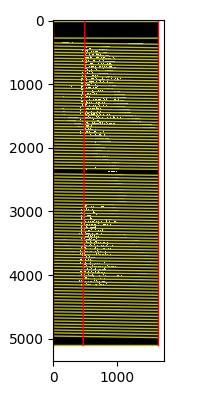

In [18]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.imshow(left_side, cmap=plt.cm.gray)

for ((x0, y0), (x1, y1)) in horiz_lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in vert_lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.tight_layout()
plt.show()

## Get grid cells in the left side of the image

We want the interior area of each cell.

In [20]:
class Cell:

    def __init__(self, image, north=None, south=None, east=None, west=None):
        self.image = image
        self.east = east
        self.west = west
        self.north = north
        self.south = south

    def interior(self):

        # East vertical line
        (ex0, ey0), (ex1, ey1) = self.east

        # West vertical line
        (wx0, wy0), (wx1, wy1) = self.west

        # North horizontal line
        (nx0, ny0), (nx1, ny1) = self.north

        # South horizontal line
        (sx0, sy0), (sx1, sy1) = self.south

        # Get the interior of the cell
        east = max(ex0, ex1)
        north = max(ny0, ny1)
        south = image.shape[0] - min(sy0, sy1)
        west = image.shape[1] - min(wy0, wy1)

        return util.crop(image, ((north, south), (east, west)))

In [ ]:
cells = [Cell(left_side, n, s, e, w) for (n, s), (e, w) in product(
    zip(horiz_lines[:-1], horiz_lines[1:]),
    zip(vert_lines[:-1], vert_lines[1:]))]

## Look at the second cell in each row

See if there is writing in the cell

In [ ]:
horiz_line_pairs = list(zip(horiz_lines[:-1], horiz_lines[1:]))

writing = np.linspace(80.0, 100.0, num=201)
print(writing)
writing = np.deg2rad(writing)

A function for getting a cell.

## Find rows with labels

In [ ]:
has_row_label = [np.mean(row_label_cell(left_side, pair, vert_lines[0])) > 20 
                 for pair in horiz_line_pairs]
print(has_row_label)

Crop the right side to have only rows with labels

In [ ]:
threshold = left_side.shape[1] * 0.4
sort_key = lambda x: x[1][1]

horiz_lines, horiz_angles = get_lines(left_side, near_horiz, threshold, sort_key)
print(len(horiz_lines))
print(np.rad2deg(horiz_angles)

In [ ]:
threshold = left_side.shape[0] * 0.4
sort_key = lambda x: x[0][0]

vert_lines, vert_angles = get_lines(left_side, near_vert, threshold, sort_key)

print(len(vert_lines))
print(vert_lines)
print(np.rad2deg(vert_angles))

## Look for a method to determine if a cell has writing

In [ ]:
cutoff = 20


@interact(index=(0, len(horiz_line_pairs) - 1))
def draw_label_cell(index):
    fig, ax = plt.subplots(figsize=(4, 1))

    (v0, w0), (v1, w1) = vert_lines[0]
    east = max(v0, v1)

    (((p0, q0), (p1, q1)), ((x0, y0), (x1, y1))) = horiz_line_pairs[index]
    north = max(q0, q1)
    south = left_side.shape[0] - min(y0, y1)
    west = left_side.shape[1] - east - 200
    cell = util.crop(left_side, ((north, south), (east, west)))  # , copy=True)
    ax.imshow(cell, cmap=plt.cm.gray)
    # lines = probabilistic_hough_line(cell, line_length=20)
    # print('lines', len(lines), 'mean', np.mean(cell))
    # print('YES' if len(lines) > 2 else '')
    mean = np.mean(cell)
    print('mean', mean)
    print('YES' if mean > cutoff else '')

    plt.tight_layout()
    plt.show()

## Look for grid lines.

We want to find the horizontal and vertical grid lines. Because the images are scanned the lines may not be exactly level or straight. So we're looking for lines within a few degrees of horizontal or vertical in small degree increments. Preliminary tests have shown this to be successful for this set of images. Degrees are converted into radians.

We need to swap the image to black on white in the image because the implementation of the Hough transform counts white pixels.

In [ ]:
edges, image = preprocess_image('images/Boyd_M_Bird_journal_section1-024.png')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(edges, cmap=plt.cm.gray)

### Split the image into sections.

The images are large and the lines are skewed or incomplete. This causes the Hough transform return lines that don't align with the grid throughout the image or miss lines altogether. Breaking the image into sections helps with this.

In [ ]:
print(image.shape)

# Chop image vertically to get horizontal lines

split = int(image.shape[1] / 2)

left_beg = 0
left_end = split

right_beg = split
right_end = image.shape[1]

left_side = util.crop(edges, ((0, 0), (0, split)), copy=True)
right_half = util.crop(edges, ((0, 0), (split, 0)), copy=True)


# Chop image horizontally to get vertical lines

split = int(image.shape[0] / 3)

top_beg = 0
top_end = split

middle_beg = split
middle_end = split * 2

bottom_beg = split * 2
bottom_end = split * 3

top_3rd = util.crop(edges, ((0, split * 2), (0, 0)), copy=True)
middle_3rd = util.crop(edges, ((split, split), (0, 0)), copy=True)
bottom_3rd = util.crop(edges, ((split * 2, 0), (0, 0)), copy=True)

Find horizontal grid lines

In [ ]:
threshold = edges.shape[1] * 0.15
sort_key = lambda x: x[1][1]

horiz_lines = get_lines(edges, near_horiz, threshold, sort_key)

left_side_lines = get_lines(left_side, near_horiz, threshold, sort_key)
right_half_lines = get_lines(right_half, near_horiz, threshold, sort_key)

print('all', len(horiz_lines))
print('left', len(left_side_lines))
print('right', len(right_half_lines))

Find vertical grid lines

In [ ]:
threshold = edges.shape[0] * 0.20
sort_key = lambda x: x[0][0]

vert_lines = get_lines(edges, near_vert, threshold, sort_key)

top_3rd_lines = get_lines(top_3rd, near_vert, threshold, sort_key)
middle_3rd_lines = get_lines(middle_3rd, near_vert, threshold, sort_key)
bottom_3rd_lines = get_lines(bottom_3rd, near_vert, threshold, sort_key)

print('all', len(vert_lines))
print('top', len(top_3rd_lines))
print('middle', len(middle_3rd_lines))
print('bottom', len(bottom_3rd_lines))

Visually inspect the lines returned by the Hough transform.

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.imshow(image, cmap=plt.cm.gray)
ax.set_title('Hough Lines')

for ((x0, y0), (x1, y1)) in left_side_lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in right_half_lines:
    ax.plot((x0 + right_beg, x1 + right_beg), (y0, y1), '-r', linewidth=1)

for ((x0, y0), (x1, y1)) in top_3rd_lines:
    ax.plot((x0, x1), (y0, y1), '-c', linewidth=1)

for ((x0, y0), (x1, y1)) in middle_3rd_lines:
    ax.plot((x0, x1), (y0 + middle_beg, y1 + middle_beg), '-g', linewidth=1)

for ((x0, y0), (x1, y1)) in bottom_3rd_lines:
    ax.plot((x0, x1), (y0 + bottom_beg, y1 + bottom_beg), '-b', linewidth=1)

plt.tight_layout()
plt.show()

## Conclusion from the image splitting experiments

From this we can see that we want to shrink the image as much as possible. We're going to look for cells with writing in them and split the image horizontally when we get a streak of empty row labels. We will reassemble the image for reporting.

## Look for labeled rows

In theory, a data row could have no marks in it (i.e. the bird species did not appear all month) or a non-data row could have extraneous marks in it. We will look for some writing in the row label cells to determine if a row is data row.

So we will be looking at the left side of the vertical split only.

## Look for presence or absence marks in the data cells

## Failed experiments

## Try merging endpoints

If it works then it will simplify things a lot.

In [ ]:
horiz_points = [[l0, [x + right_beg, y]]
                for (l0, l1), (r0, (x, y)) in zip(left_side_lines, right_half_lines)]

fig, ax = plt.subplots(figsize=(9, 6))

ax.imshow(image, cmap=plt.cm.gray)
ax.set_title('Merged Hough Lines')

for ((x0, y0), (x1, y1)) in horiz_points:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

vert_points = []
for (t0, t1), (b0, (x, y)) in zip(top_3rd_lines[2:], bottom_3rd_lines[1:]):
    vert_points.append([t0, [x, y + bottom_beg]])

for ((x0, y0), (x1, y1)) in vert_points:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.tight_layout()
plt.show()

### Probabilistic Hough line

It proved to be much slower and harder to tune for finding grid lines that span the entire image.

In [ ]:
threshold = edges.shape[1] * 0.2

lines = probabilistic_hough_line(edges, threshold=threshold, line_length=50, line_gap=100, theta=near_horiz)
print(len(lines))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(image, cmap=plt.cm.gray)
ax.set_title('Probabilistic Horizontal Hough Lines')

for (p0, p1) in lines:
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), '-r', linewidth=1)

plt.tight_layout()
plt.show()

### OpenCV

This works, it's just less flexible for searching on a limited set of angles. The ability to pull out the horizontal, vertical, and diagonal lines separately is useful in this application.

This function reads in an image and performs needed preprocessing to get the image into a form the algorithms can use efficiently.

In [ ]:
def preprocess_image_cv2(file_name):
    image = cv2.imread(file_name)
    edges = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # edges = cv2.Canny(edges, 50, 150, apertureSize=3)
    return edges, image

In [ ]:
edges, image = preprocess_image_cv2('images/Boyd_M_Bird_journal_section1-024.png')
print(image.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image, cmap=plt.cm.gray)

In [ ]:
threshold = int(image.shape[1] * 0.2)
rho_resolution = 1                # in pixels
theta_resolution = np.pi / 360.0  # in radians

lines = cv2.HoughLines(edges, rho_resolution, theta_resolution, threshold)
print(len(lines))

In [ ]:
img = np.copy(image)
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + img.shape[0] * -b)
    y1 = int(y0 + img.shape[0] * a)
    x2 = int(x0 - img.shape[1] * -b)
    y2 = int(y0 - img.shape[1] * a)

    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img, cmap=plt.cm.gray)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(edges, cmap=plt.cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(image, cmap=plt.cm.gray)
ax[1].set_title('Raw Image')

plt.tight_layout()
plt.show()